In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import load_mnist
import time

In [2]:
tf.__version__

'1.9.0'

In [3]:
from cnn_model import model

In [4]:
def reshape_image(x):
    x = np.transpose(x,[0,2,3,1])
    return x

In [5]:
mnist = dict()
mnist['train_x'],mnist['train_y'],mnist['test_x'],mnist['test_y'] = load_mnist.load_mnist_dataset(os.getcwd()+"/fashion")
mnist['train_x'].shape,mnist['test_x'].shape

((60000, 1, 28, 28), (10000, 1, 28, 28))

In [6]:
mnist['train_x'] = reshape_image(mnist['train_x']/255)
mnist['test_x'] = reshape_image(mnist['test_x']/255)

In [7]:
mnist['train_x'].shape,mnist['test_x'].shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

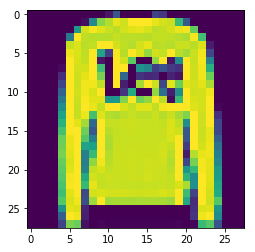

In [8]:
num = 1
plt.imshow(mnist['test_x'][num,:,:,:].reshape((28,28)))
plt.show()

In [9]:
batch_size = 100

In [10]:
#train
with tf.variable_scope("Dataset_pipeline"):
    dtrain_x = tf.data.Dataset.from_tensor_slices(mnist['train_x'])
    dtrain_y = tf.data.Dataset.from_tensor_slices(mnist['train_y']).map(lambda x: tf.one_hot(x,10))
    train_data = tf.data.Dataset.zip((dtrain_x,dtrain_y)).shuffle(1000).repeat().batch(batch_size)
    
    train_one_shot = tf.data.Dataset.zip((dtrain_x,dtrain_y)).batch(batch_size)
    
    
    dtest_x = tf.data.Dataset.from_tensor_slices(mnist['test_x'])
    dtest_y = tf.data.Dataset.from_tensor_slices(mnist['test_y']).map(lambda x: tf.one_hot(x,10))
    test_data = tf.data.Dataset.zip((dtest_x,dtest_y)).batch(batch_size)
    
    dvalid_x = tf.data.Dataset.from_tensor_slices(mnist['test_x'][:1001])
    dvalid_y = tf.data.Dataset.from_tensor_slices(mnist['test_y'][:1001]).map(lambda x: tf.one_hot(x,10))
    valid_data =  tf.data.Dataset.zip((dvalid_x,dvalid_y)).repeat().batch(batch_size)

(train_data,test_data,valid_data)

(<BatchDataset shapes: ((?, 28, 28, 1), (?, 10)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((?, 28, 28, 1), (?, 10)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((?, 28, 28, 1), (?, 10)), types: (tf.float32, tf.float32)>)

In [11]:
# data pipline iterator initializer
iterator = tf.data.Iterator.from_structure(train_data.output_types,train_data.output_shapes)
get_batch = iterator.get_next()
#train data 1 shot
train_1s_init = iterator.make_initializer(train_one_shot)
#train data initiallizer shuffled
train_init = iterator.make_initializer(train_data)
#test data initializer shuffled
test_init = iterator.make_initializer(test_data)
# test data one shot initializer
valid_init = iterator.make_initializer(valid_data)

In [12]:
param=[]
param.append(1)
param.append([5,64])
param.append([5,64])
param.append(1500)
param.append(10)
len(param)

5

In [13]:
is_train = tf.placeholder(shape=(),dtype=tf.bool)
prob_keep = tf.placeholder(shape=(),dtype=tf.float32)
cnn = model(get_batch[0],is_train,prob_keep,param)

In [14]:
logits = cnn.logits
info = cnn.total_params()

varname : conv_1/weight:0 [Dimension(5), Dimension(5), Dimension(1), Dimension(64)]
varname : conv_1/bias:0 [Dimension(64)]
varname : conv_2/weight:0 [Dimension(5), Dimension(5), Dimension(64), Dimension(64)]
varname : conv_2/bias:0 [Dimension(64)]
varname : dense/kernel:0 [Dimension(3136), Dimension(1500)]
varname : dense/bias:0 [Dimension(1500)]
varname : dense_1/kernel:0 [Dimension(1500), Dimension(10)]
varname : dense_1/bias:0 [Dimension(10)]
total number of trainable parameter : 4824638


In [15]:

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=get_batch[1],logits=logits))

tf.summary.scalar("losses",loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
conf_mtx = tf.confusion_matrix(labels=tf.argmax(get_batch[1],axis=1),predictions = tf.argmax(logits,axis=1),num_classes=10)
#get accuracy
predictions = tf.argmax(logits,axis=1)
equality = tf.equal(predictions,tf.argmax(get_batch[1],axis=1))
accuracy = tf.reduce_mean(tf.cast(equality,tf.float32))
tf.summary.scalar("accuracy",accuracy)
init_op = tf.global_variables_initializer()

In [16]:
log_dir = '/output/logs_fashion'
print(log_dir)
t_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(log_dir)
saver = tf.train.Saver()

/output/logs_fashion


In [17]:
epochs = 0.5
epochs = int(epochs*60000/(batch_size))
probability_keep = 0.5

In [18]:
duration = 0
confusion_matrix = np.zeros((10,10),dtype=np.int32)
with tf.Session() as sess:
    #saver.restore(sess,log_dir+'/curr_model.ckpt')
    writer.add_graph(sess.graph)
    sess.run(init_op)
    train_log_loss=[]
    valid_log_acc =[]
    for i in range(1,epochs+1):
        sess.run(train_init)
        start_time = time.time()
        l,_,acc,s = sess.run([loss,optimizer,accuracy,t_summary],feed_dict={is_train:True,prob_keep:probability_keep})
        duration = duration + time.time() - start_time
        #print("loss  : "+str(l))
        writer.add_summary(s,i)
        # history of loss and accuracy while training
        train_log_loss.append(l)
        
        if i%100==0:
            print("Epoch :{}, loss :{:.3f}, accuracy :{:.3f}".format(i,l,acc))
            save_path = saver.save(sess,log_dir+'/curr_model.ckpt')    
            valid_iter = 10
            avg_acc = 0
            sess.run(valid_init)
            for _ in range(valid_iter):
                acc = sess.run([accuracy],feed_dict = {is_train:False,prob_keep:1.0})
                avg_acc+=acc[0]
            avg_acc=avg_acc*100.0/10
            valid_log_acc.append(avg_acc)
            print("average accuracy :{:.2f}".format(avg_acc))
        if i>600 and avg_acc>=84.3:
            break
        
    
    
    print("total training duration : {} sec".format(duration))
    #final accuracy on test data
    i=0
    test_acc = 0
    sess.run(test_init)
    while True:
        try:
            #100 --> batch size for one_shot_iter is 100
            acc,cfmx = sess.run([accuracy,conf_mtx],feed_dict = {is_train:False,prob_keep:1.0})
            confusion_matrix = confusion_matrix + cfmx
            i+=1
            test_acc+=acc
        except tf.errors.OutOfRangeError:
            print("number of iter  : {}".format(i))
            print("Test Accuracy: {}".format(test_acc*100/i))
            test_acc = test_acc*100/i
            plt.plot(train_log_loss,label='loss_train',color='r')
            plt.plot(valid_log_acc,label='acc_train',color='b')
            plt.xlabel("epochs")
            plt.legend()
            plt.show()
            break
    train_acc = 0
    i = 0
    sess.run(train_1s_init)
    while True:
        try:
            acc = sess.run([accuracy],feed_dict = {is_train:False,prob_keep:1.0})
            i+=1
            train_acc+=acc[0]
        except:
            train_acc = train_acc*100/i
            print("train accuracy : {:.3}".format(train_acc))
            break                
                  


KeyboardInterrupt: 

In [ ]:
mnist_dict = dict()
mnist_dict['batch_size'] = batch_size
mnist_dict['confusion_matrix'] = confusion_matrix
mnist_dict['epochs'] = epochs
mnist_dict['param_info'] = info
mnist_dict['duration'] = np.array([duration])
mnist_dict['loss'] = np.array(train_log_loss)
mnist_dict['accuracy'] = np.array(valid_log_acc)
mnist_dict['test_accuracy'] = np.array(test_acc)
mnist_dict['train_accuracy'] = np.array(train_acc)
np.save('/floyd/home/fashion_logs_saves_30e.npy',mnist_dict)

In [ ]:
mnist_dict['confusion_matrix']